In [26]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt

In [41]:
# Load CSVs
df_day_minus1 = pd.read_csv("prices_round_2_day_-1.csv", delimiter=";")
df_day_0 = pd.read_csv("prices_round_2_day_0.csv", delimiter=";")
df_day_1 = pd.read_csv("prices_round_2_day_1.csv", delimiter=";")

# Helper function to process a day’s DataFrame
def make_day_df(df):
    # Filter to only needed products
    products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
    df_filtered = df[df["product"].isin(products)][["timestamp", "product", "mid_price"]]
    
    # Pivot to wide format
    df_pivot = df_filtered.pivot(index="timestamp", columns="product", values="mid_price").reset_index()
    
    # Compute synthetic baskets
    df_pivot["SYNTHETIC_PICNIC_BASKET1"] = (
        6 * df_pivot["CROISSANTS"] + 3 * df_pivot["JAMS"] + 1 * df_pivot["DJEMBES"]
    )
    df_pivot["SYNTHETIC_PICNIC_BASKET2"] = (
        4 * df_pivot["CROISSANTS"] + 2 * df_pivot["JAMS"]
    )
    
    return df_pivot

# Process each day
df_day_minus1 = make_day_df(df_day_minus1)
df_day_0 = make_day_df(df_day_0)
df_day_1 = make_day_df(df_day_1)

# Make copies to avoid modifying originals
df_minus1 = df_day_minus1.copy()
df_0 = df_day_0.copy()
df_1 = df_day_1.copy()

def normalize_timestamps(df):
    df = df.copy()
    df["timestamp"] = range(len(df))
    return df

# Normalize timestamps before offsetting
df_minus1 = normalize_timestamps(df_minus1)
df_0 = normalize_timestamps(df_0)
df_1 = normalize_timestamps(df_1)

# Get lengths
len_minus1 = len(df_minus1)
len_0 = len(df_0)

# Apply offset
df_0["timestamp"] += len_minus1
df_1["timestamp"] += len_minus1 + len_0

# Concatenate all days
df_all_days = pd.concat([df_minus1, df_0, df_1], axis=0).reset_index(drop=True)



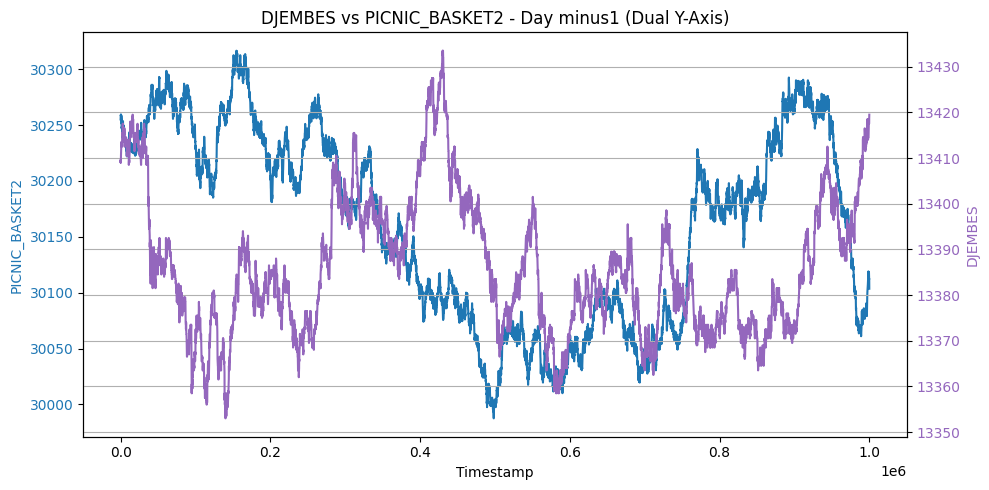

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot CROISSANTS on the left y-axis
ax1.plot(df_day_1["timestamp"], df_day_1["PICNIC_BASKET2"], color="tab:blue", label="PICNIC_BASKET2")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("PICNIC_BASKET2", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create second y-axis for JAMS
ax2 = ax1.twinx()
ax2.plot(df_day_1["timestamp"], df_day_1["DJEMBES"], color="tab:purple", label="DJEMBES")
ax2.set_ylabel("DJEMBES", color="tab:purple")
ax2.tick_params(axis="y", labelcolor="tab:purple")

plt.title("DJEMBES vs PICNIC_BASKET2 - Day minus1 (Dual Y-Axis)")
plt.grid(True)
plt.tight_layout()
plt.show()

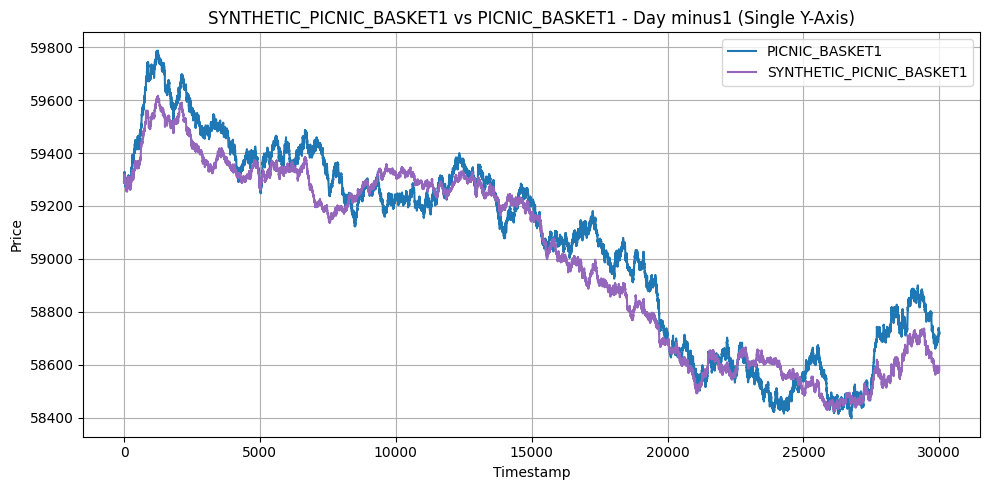

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot both on the same y-axis
ax1.plot(df_all_days["timestamp"], df_all_days["PICNIC_BASKET1"], color="tab:blue", label="PICNIC_BASKET1")
ax1.plot(df_all_days["timestamp"], df_all_days["SYNTHETIC_PICNIC_BASKET1"], color="tab:purple", label="SYNTHETIC_PICNIC_BASKET1")

ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Price")
ax1.set_title("SYNTHETIC_PICNIC_BASKET1 vs PICNIC_BASKET1 - Day minus1 (Single Y-Axis)")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()

In [73]:
df_all_days['DIFF_1'] = df_all_days['PICNIC_BASKET1'] - df_all_days['SYNTHETIC_PICNIC_BASKET1'] - 48.75

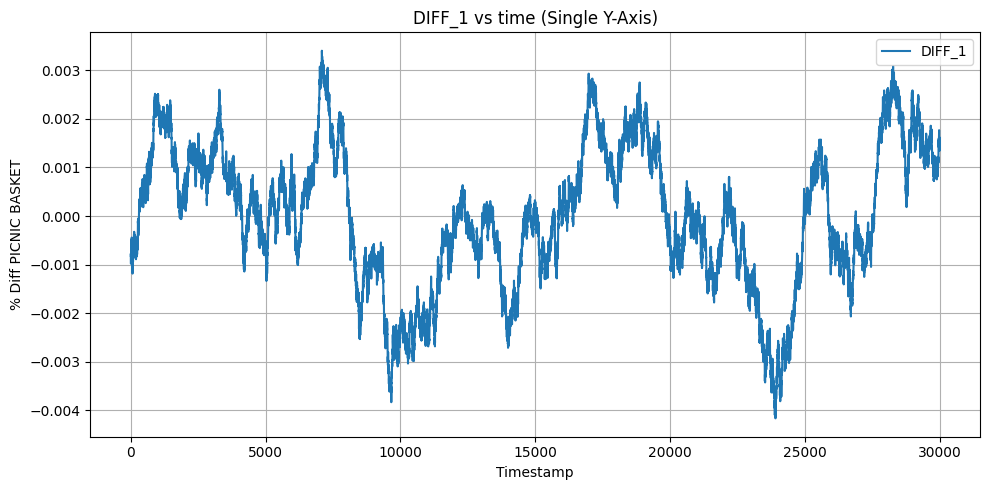

In [74]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot both on the same y-axis
ax1.plot(df_all_days["timestamp"], df_all_days["DIFF_1"]/df_all_days['PICNIC_BASKET1'], color="tab:blue", label="DIFF_1")

ax1.set_xlabel("Timestamp")
ax1.set_ylabel("% Diff PICNIC BASKET")
ax1.set_title("DIFF_1 vs time (Single Y-Axis)")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()

In [75]:
mean_diff = df_all_days["DIFF_1"].mean()
std_diff = df_all_days["DIFF_1"].std()
mean_line = mean_diff - 48.75
std_upper = mean_diff + (0.5 * std_diff) - 48.75
std_lower = mean_diff - (0.5 * std_diff) - 48.75

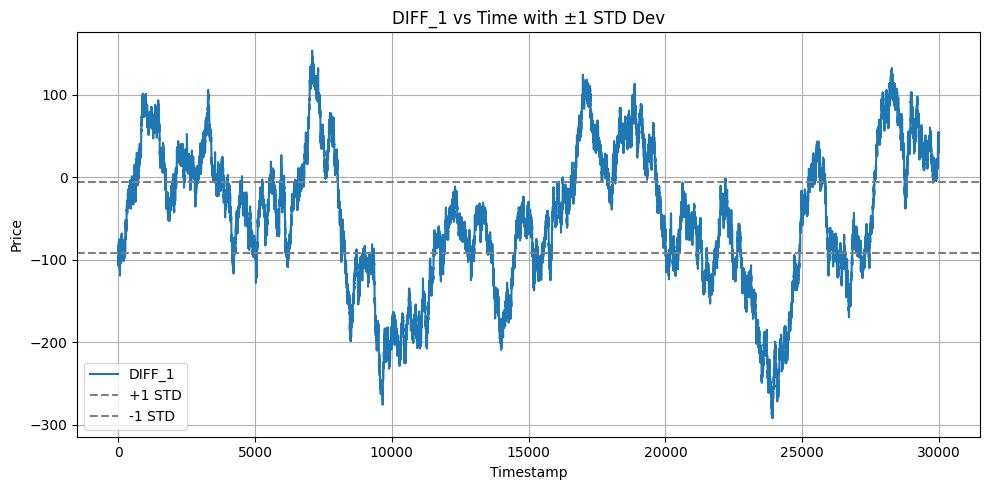

In [76]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df_all_days["timestamp"], df_all_days["DIFF_1"] - 48.75, color="tab:blue", label="DIFF_1")

# Add dashed horizontal lines
ax1.axhline(std_upper, color="gray", linestyle="--", label="+1 STD")
ax1.axhline(std_lower, color="gray", linestyle="--", label="-1 STD")

ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Price")
ax1.set_title("DIFF_1 vs Time with ±1 STD Dev")
ax1.grid(True)
ax1.legend()
plt.tight_layout()
plt.show()

In [77]:
mean_diff = df_all_days["DIFF_1"].mean()
std_diff = df_all_days["DIFF_1"].std()

upper = mean_diff + std_diff
lower = mean_diff - std_diff

# Initialize variables
outside = False
counter = 0
reentry_times = []

# Iterate over the series
for val in df_all_days["DIFF_1"]:
    if not outside:
        if val > upper or val < lower:
            outside = True
            counter = 0
    else:
        counter += 1
        if lower <= val <= upper:
            reentry_times.append(counter)
            outside = False

# Calculate mean reentry time
mean_reentry_time = np.mean(reentry_times)
print("Mean reentry time into ±1 STD zone:", mean_reentry_time * 100)

Mean reentry time into ±1 STD zone: 4360.944206008584
